In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

data_sample = pd.read_csv('sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1905,00009993_000.png,No Finding,0,9993,044Y,F,AP,2500,2048,0.168,0.168
2578,00012931_033.png,No Finding,33,12931,047Y,F,AP,2500,2048,0.168,0.168
1974,00010335_000.png,Nodule,0,10335,051Y,F,PA,2370,2801,0.143,0.143


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
all_diseases = set()
for finding in all_xray_df['Finding Labels']:
    for disease in finding.split('|'):
        all_diseases.add(disease)

all_diseases = list(all_diseases)
for disease in all_diseases:
    all_xray_df[disease] = all_xray_df['Finding Labels'].map(lambda x: disease in x.split('|')).astype(int)

In [4]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Mass,Effusion,Cardiomegaly,Infiltration,Fibrosis,Consolidation,Pleural_Thickening,Edema,Nodule
3045,00000808_003.png,No Finding,3,808,51,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,0
77640,00019087_026.png,Infiltration,26,19087,33,M,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0
7097,00001876_000.png,Infiltration,0,1876,54,M,PA,2048,2500,0.171,...,0,0,0,0,1,0,0,0,0,0


In [5]:
pneumonia_pos_df = all_xray_df[all_xray_df['Pneumonia'] == 1]
total_pneumonia = pneumonia_pos_df.shape[0]
total = all_xray_df.shape[0]
percentage = (100.0 * total_pneumonia) / total
print("Pneumonia-positive: {} ({} %)".format(total_pneumonia, percentage))
print("Total: {}".format(total))

Pneumonia-positive: 1431 (1.2763110952550838 %)
Total: 112120


There is clearly a class imbalance. Out of 112,120 X-rays, only 1430 of them (approximately 1.28%) are marked as positive for having pneumonia.

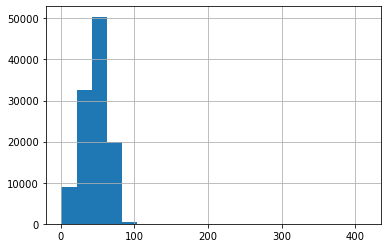

In [6]:
all_xray_df['Patient Age'].hist(bins=20)

There seem to be some outliers. The longest human lifespan in recorded history is 122 years. 

In [7]:
ages_over_122 = all_xray_df[all_xray_df['Patient Age'] > 122]['Patient Age']
print(ages_over_122.shape)

(16,)


In [8]:
ages_over_122

20852     412
46965     414
48284     148
55742     148
58650     150
62929     149
74884     152
78795     151
84810     411
85404     412
86264     413
91369     412
95794     153
98495     154
101194    155
104590    155
Name: Patient Age, dtype: int64

There are only 16 records (out of over 112,000) for which the ages are over 122. It's safe to assume that these are the result of errors in data entry and that they can be ignored when analyzing age distribution.

Overall Age Statistics:
- Mean: 46.872573681581386
- Median: 49.0
- Standard deviation: 16.598151885747132
- 50% of X-rays in age range 35.0 - 59.0
- 75% of X-rays in age range 25.0 - 65.0
Pneumonia Age Statistics:
- Mean: 44.67062937062937
- Median: 46.0
- Standard deviation: 17.639097629242386
- 50% of X-rays in age range 31.0 - 59.0
- 75% of X-rays in age range 23.0 - 65.0


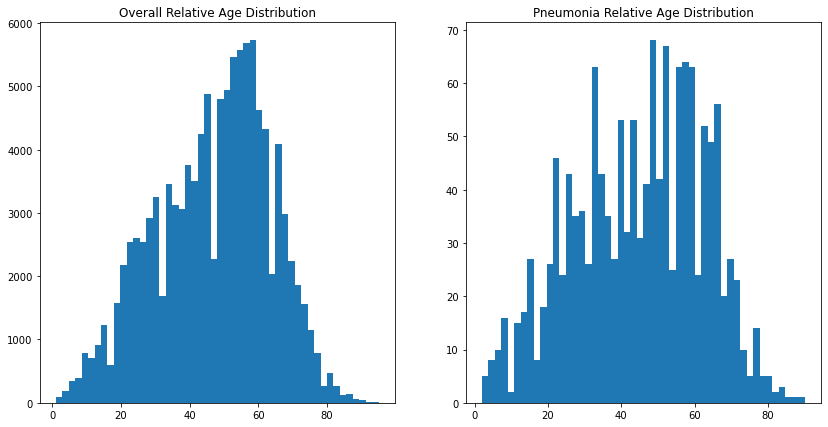

In [9]:
f = plt.figure(figsize=(14,7))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

all_age_filtered_df = all_xray_df[all_xray_df['Patient Age'] <= 122]
pneumonia_age_filtered_df = all_age_filtered_df[all_age_filtered_df['Pneumonia'] == 1]

overall_ages = all_age_filtered_df['Patient Age']
pneumonia_ages = pneumonia_age_filtered_df['Patient Age']

ax.hist(overall_ages, bins=50)
ax.set_title('Overall Relative Age Distribution')
ax2.hist(pneumonia_ages, bins=50)
ax2.set_title('Pneumonia Relative Age Distribution')

print("Overall Age Statistics:")
print("- Mean: {}".format(overall_ages.mean()))
print("- Median: {}".format(overall_ages.median()))
print("- Standard deviation: {}".format(overall_ages.std()))
print("- 50% of X-rays in age range {} - {}".format(overall_ages.quantile(0.25), overall_ages.quantile(0.75)))
print("- 75% of X-rays in age range {} - {}".format(overall_ages.quantile(0.125), overall_ages.quantile(0.875)))

print("Pneumonia Age Statistics:")
print("- Mean: {}".format(pneumonia_ages.mean()))
print("- Median: {}".format(pneumonia_ages.median()))
print("- Standard deviation: {}".format(pneumonia_ages.std()))
print("- 50% of X-rays in age range {} - {}".format(pneumonia_ages.quantile(0.25), pneumonia_ages.quantile(0.75)))
print("- 75% of X-rays in age range {} - {}".format(pneumonia_ages.quantile(0.125), pneumonia_ages.quantile(0.875)))

In [10]:
pearsonr(all_age_filtered_df['Patient Age'], all_age_filtered_df['Pneumonia'])

(-0.01507973637273614, 4.4362142784372045e-07)

The Pearson correlation coefficient for age and pneumonia status is -0.015, with a p-value of 4.4e-7. This shows that, while there clearly is a correlation, that correlation is very minor. Additionally, the age distributions for the overall dataset and for the pneumonia-positive X-rays are roughly the same.

Text(0.5, 1.0, 'Overall Gender Distribution: 58.56044723969252% Male')

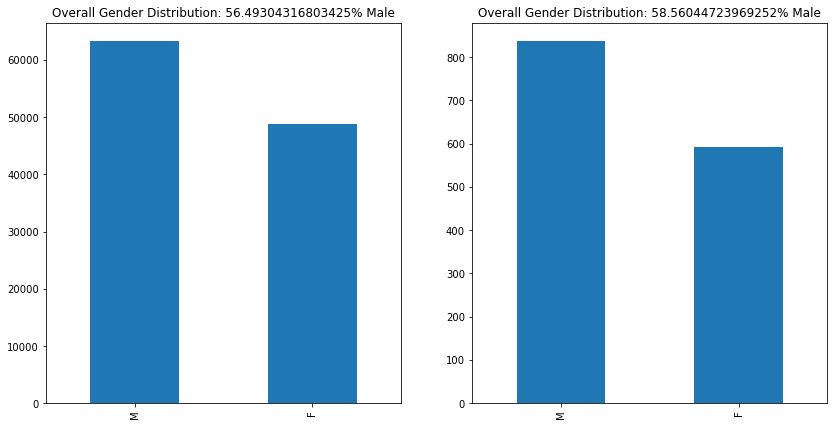

In [11]:
f = plt.figure(figsize=(14,7))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

overall_ages = all_xray_df['Patient Gender'].value_counts()
pneumonia_ages = pneumonia_pos_df['Patient Gender'].value_counts()

overall_male = (100.0 * overall_ages['M']) / all_xray_df.shape[0]
pneumonia_male = (100.0 * pneumonia_ages['M']) / pneumonia_pos_df.shape[0]

overall_ages.plot(kind='bar', ax=ax)
ax.set_title('Overall Gender Distribution: {}% Male'.format(overall_male))
pneumonia_ages.plot(kind='bar', ax=ax2)
ax2.set_title('Overall Gender Distribution: {}% Male'.format(pneumonia_male))

In [12]:
pearsonr(all_xray_df['Patient Gender'] == 'M', all_xray_df['Pneumonia'])

(0.004741503918080045, 0.11236510017963604)

There does not appear to be any correlation between gender and having pneumonia. The gender breakdown for the overall dataset and for the X-rays that show pneumonia are roughly the same (56% vs 58%).

Text(0.5, 1.0, 'Overall Position Distribution: 44.0251572327044% PA')

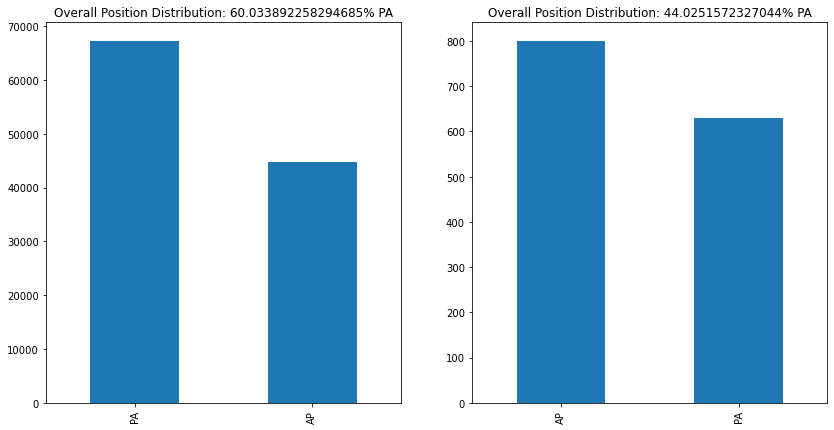

In [13]:
f = plt.figure(figsize=(14,7))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

overall_positions = all_xray_df['View Position'].value_counts()
pneumonia_positions = pneumonia_pos_df['View Position'].value_counts()

overall_pa = (100.0 * overall_positions['PA']) / all_xray_df.shape[0]
pneumonia_pa = (100.0 * pneumonia_positions['PA']) / pneumonia_pos_df.shape[0]

overall_positions.plot(kind='bar', ax=ax)
ax.set_title('Overall Position Distribution: {}% PA'.format(overall_pa))
pneumonia_positions.plot(kind='bar', ax=ax2)
ax2.set_title('Overall Position Distribution: {}% PA'.format(pneumonia_pa))

In [14]:
pearsonr(all_xray_df['View Position'] == 'PA', all_xray_df['Pneumonia'])

(-0.03716040367245936, 1.4507331350242956e-35)

The Pearson correlation coefficient for view position and pneumonia status is -0.037, with a p-value of 2e-35. The overall dataset is about 60% PA, whereas the X-rays that show pneumonia are only 44% PA. This shows that X-rays that are in the "AP" position are more likely to show pneumonia.

There are many patients who have multiple X-rays in this dataset, as shown by the "Follow-up #" column. The distribution of this value is shown below.

Text(0.5, 1.0, 'Pneumonia Follow-up # Distribution')

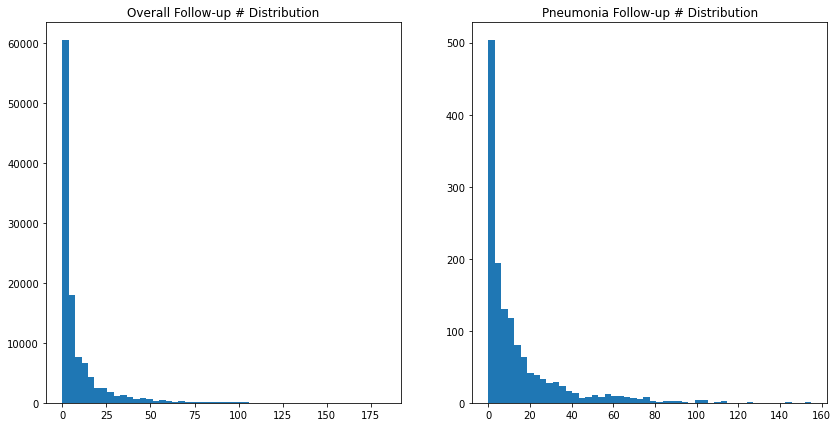

In [15]:
f = plt.figure(figsize=(14,7))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

overall_follow_up = all_xray_df['Follow-up #']
pneumonia_follow_up = pneumonia_pos_df['Follow-up #']

ax.hist(overall_follow_up, bins=50)
ax.set_title('Overall Follow-up # Distribution')
ax2.hist(pneumonia_follow_up, bins=50)
ax2.set_title('Pneumonia Follow-up # Distribution')

In [16]:
pearsonr(all_xray_df['Follow-up #'], all_xray_df['Pneumonia'])

(0.04321367428475321, 1.7079276075149824e-47)

The Pearson correlation coefficient for follow-up number and whether an X-ray shows pneumonia is 0.04, with a p-value of 1.3e-347. This shows that an X-ray is more likely to show pneumonia if it is a higher follow-up number.

Another question to consider is which other diseases are most strongly correlated with pneumonia. To answer this question, only diseases with correlation coefficients for which the p-value is less than 0.05 will be considered.

In [17]:
for disease in all_diseases:
    if disease in ['Pneumonia', 'No Finding']:
        continue
    coeff, p_value = pearsonr(all_xray_df['Pneumonia'], all_xray_df[disease])
    if p_value < 0.05:
        print(disease)
        print('- Correlation:', coeff)
        print('- P-value', p_value)

Pneumothorax
- Correlation: -0.009983715702987932
- P-value 0.0008287018933926505
Atelectasis
- Correlation: 0.029911097888098575
- P-value 1.274871741292356e-23
Effusion
- Correlation: 0.024322351850950105
- P-value 3.7837610814725215e-16
Infiltration
- Correlation: 0.07302012740836605
- P-value 2.2575244751557635e-132
Fibrosis
- Correlation: -0.006867347166726319
- P-value 0.02147734055129956
Consolidation
- Correlation: 0.0252353194733541
- P-value 2.8850219342268904e-17
Edema
- Correlation: 0.17399625506130395
- P-value 0.0


<h5>Conclusions</h5>

- The dataset consists of 112,120 X-rays, out of which 1430 (or about 1.28%) are marked as positive for pneumonia.
- The X-rays were taken on men about 56% of the time. The overall gender ratio is roughly the same as the gender ratio for X-rays that show pneumonia.
- For the overall dataset, the average age is 47, with a median age of 49 and a standard deviation of 17. For the X-rays that show pneumonia, the average age is 45, with a median age of 46 and a standard deviation of 18. There is a slight correlation between age and pneumonia-positivity (-0.015)
- Overall, about 60% of the X-rays were taken in the PA position. However, only about 44% of the X-rays showing pneumonia were in the PA position. There is a correlation (-0.037) between the position being PA and the X-ray showing pneumonia.
- It's more common for a patient to have fewer follow-ups. The more follow-ups a patient has, the more likely they are to have an X-ray that shows pneumonia. The correlation between follow-up number and having pneumonia is about 0.04.
- The diseases that correlate with pneumonia are edema (0.174), infiltration (0.073), atelectasis (0.030), consolidation (0.025), effusion (0.024), fibrosis (-0.007), and pneumothorax (-0.010).